# Implementing Random Forest
# 1. Baseline Model with default parameters and 629 features
# 2. Baseline model with default parameters and 300 features after TSVD
# 3. Using Cross-Validation to Train the model with hyper parameters
# 4. Using Calibration to create a best fit model
# 5. Test the model with testing data

References:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_multiclass.html#compare-probabilities
https://scikit-learn.org/stable/modules/calibration.html

# Import all the required libraries

In [1]:
#import all libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score,RocCurveDisplay, log_loss
import gc
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Patch
import joblib
from sklearn.metrics import zero_one_loss
from itertools import cycle
from collections import OrderedDict
from sklearn.model_selection import learning_curve
from matplotlib.pyplot import axes
from collections import Counter
import seaborn as sns
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20})

# Define functions to plot various graphs

In [2]:
#Define the function to plot the K-Fold data split for Model training
#CV is the cross validation model
# X, y, - Train data
# n_splits - Number of K-Folds
def plot_cv_indices(cv, X, y, n_splits):
    #lw is the height of each bar in the graph
    lw=20
    fig, ax = plt.subplots(figsize=(8, 6))
    cmap_data = plt.cm.Paired
    cmap_cv = plt.cm.coolwarm

    """Create a sample plot for indices of a cross-validation object."""
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0
    # Create a scatter on the data split
        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin = -0.1,
            vmax = 1.1,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    #Set styling and axis titles etc for the plot
    # Formatting
    yticklabels = list(range(n_splits)) + ["class"]
    ax.set(
        yticks=np.arange(n_splits + 1) + 0.5,
        yticklabels=yticklabels,
        xlabel="Index",
        ylabel="K Fold",
        ylim=[n_splits + 1.1, -0.1],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=20)
    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02)), Patch(color=cmap_data(0.02))],
        ["Testing set", "Training set","is_duplicate =1"],
        loc=(1.02, 0.8),fontsize=11
    )
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
    plt.show()

In [3]:
#Define the function to show the prediction probability for test and train data each time the model is trained
#y_pred is the model prediction for test data
#y_pred_train is the model prediction for train data
def plot_predction_probability(y_pred,y_pred_train):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(np.arange(len(y_pred)) + 1,y_pred,
            label='Prediction Probability - Test Data',
            color='red')
    ax.plot(np.arange(len(y_pred_train)) + 1,y_pred_train,
            label='Prediction Probability - Train Data',
            color='blue')

    #ax.set_ylim((min(y_pred), max(y_pred_train)))
    ax.set_xlabel('n_estimators')
    ax.set_ylabel('Prediction Probability')

    leg = ax.legend(loc=(1.02, 0.8), fancybox=True)
    leg.get_frame().set_alpha(0.7)

    plt.show()

In [4]:
#Define the function to show the ROC-AUC curve each time the model is trained
#fpr - False Positive Rate of predictions
#tpr - True Positive rate of predictions
#roc_auc - ROC-AUC score of the predictions

def plot_ROC_AUC(fpr,tpr,roc_auc):
    lw = 2
    n_classes = 2
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,10))

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize = 15)
    plt.ylabel("True Positive Rate", fontsize = 15)
    plt.title("Receiver Operating Characteristic", fontsize = 20)
    plt.legend(loc=(1.02, 0.8))
    plt.show()

In [5]:
#Define the function to show the Learning curves -  Training score, Cross-validation score, Scalability of the model, and Performance of the model
#estimator - Trained Model
#X, Y - training data
#cv - number of cross validations

def plot_learning_curve(
        estimator,
        X,
        y,
        cv=None,
        n_jobs=None,
        train_sizes=np.linspace(0.1, 1.0, 5),
):

    axes=None
    title = "Learning Curves Random Forest \n"
    ylim=(0.0, 1.01)
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title, fontsize = 20)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples", fontsize = 11)
    axes[0].set_ylabel("Score", fontsize = 11)

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc='best')

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples", fontsize = 11)
    axes[1].set_ylabel("fit_times", fontsize = 11)
    axes[1].set_title("Scalability of the model", fontsize = 15)

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times", fontsize = 11)
    axes[2].set_ylabel("Score", fontsize = 11)
    axes[2].set_title("Performance of the model", fontsize = 15)
    plt.show()

In [6]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j

    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column

    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1

    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]]
    plt.figure(figsize=(30,4))

    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")

    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")

    plt.show()

# Implement Baseline Model

In [7]:
#Read the training dataset
df = pd.read_csv("Final_Training_V01.csv")

In [8]:
# Use seed = 1234 for reproducibility
seed = 1234
np.random.seed(seed)
df_features = df.drop("is_duplicate",axis = 1)
#split the dataset for training and validation in ratio 80:20
X_smote, X_val_smote, y_smote, y_val_smote = train_test_split(df_features,
                                                  df['is_duplicate'],
                                                  test_size=0.20,
                                                  random_state=seed)

print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_smote)
train_len = len(y_smote)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_val_smote)
test_len = len(y_val_smote)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6305242613383834 Class 1:  0.36947573866161665
---------- Distribution of output variable in train data ----------
Class 0:  0.6319198602501276 Class 1:  0.36808013974987247


# Perform Over Sampling in Class 1 to unbias the dataset from 60:40 distribution to 50:50 distribution in classes

In [9]:
from imblearn.over_sampling import RandomOverSampler
#63 : 36
over = RandomOverSampler(sampling_strategy="minority")
# transform the dataset
X_train, y_train = over.fit_resample(X_smote, y_smote)
X_val, y_val = over.fit_resample(X_val_smote, y_val_smote)

In [10]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_val)
test_len = len(y_val)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.5 Class 1:  0.5
---------- Distribution of output variable in train data ----------
Class 0:  0.5 Class 1:  0.5


# Normalize the Dataset

In [11]:
#Since we have values in features that vary because of pre-processing and TF-IDF we normalize the dataset
sc = StandardScaler()
x_train_normalized = sc.fit_transform(X_train)
x_test_normalized = sc.transform(X_val)

# RF Baseline Model without TSVD

Time taken for RF Baseline : 920.9375098999999

***********Metrics for Baseline RF ***********

Log Loss:  0.3801593437040663
Confusion Matrix: 
[[36563  4314]
 [10286 30591]]
Classification Report
              precision    recall  f1-score   support

           0       0.78      0.89      0.83     40877
           1       0.88      0.75      0.81     40877

    accuracy                           0.82     81754
   macro avg       0.83      0.82      0.82     81754
weighted avg       0.83      0.82      0.82     81754

Accuracy Score:  0.8214154659099249


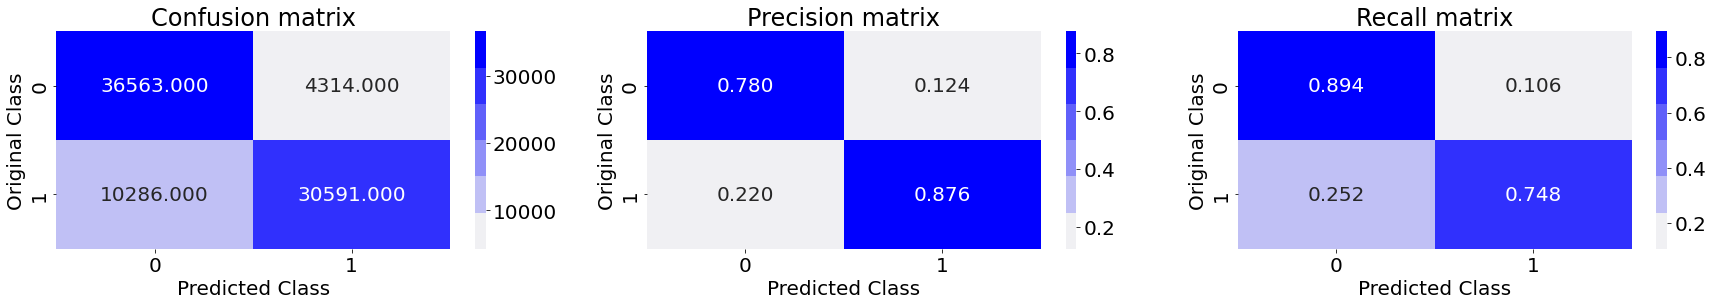

In [12]:
start = timer()
#Baseline random forest classifier model with default parameter setting
rf = RandomForestClassifier()
rf.fit(x_train_normalized, y_train)
#print time taken to train and accuracy scores
print("Time taken for RF Baseline :", timer()-start)
rf_tfidf_predict = rf.predict(x_test_normalized)
print("\n***********Metrics for Baseline RF ***********\n")
y_pred_proba = rf.predict_proba(x_test_normalized)
print("Log Loss: ", log_loss(y_val, y_pred_proba))
print("Confusion Matrix: ")
print(confusion_matrix(y_val, rf_tfidf_predict))
print("Classification Report")
print(classification_report(y_val, rf_tfidf_predict))
print("Accuracy Score: ",accuracy_score(y_val, rf_tfidf_predict))

plot_confusion_matrix(y_val, rf_tfidf_predict)

In [13]:
#Clear the memory with Garbage Collect
gc.collect()

84

# Dimension Reduction Using TSVD

In [12]:
#Reduce 629 to 300 features using TSVD
n_components = 300
svd_x_train = TruncatedSVD(n_components=n_components)
svd_x_train.fit(x_train_normalized)

svd_x_test = TruncatedSVD(n_components=n_components)
svd_x_test.fit(x_test_normalized)

x_train_after_svd = svd_x_train.transform(x_train_normalized)
x_test_after_svd = svd_x_test.transform(x_test_normalized)

# RF Baseline model using TSVD 

Time taken for RF to train after TSVD : 746.1260586999997

***********Metrics for RF After TSVD ***********

Log Loss:  0.6181936391455083
Confusion Matrix: 
[[35139  5738]
 [24508 16369]]
Classification Report
              precision    recall  f1-score   support

           0       0.59      0.86      0.70     40877
           1       0.74      0.40      0.52     40877

    accuracy                           0.63     81754
   macro avg       0.66      0.63      0.61     81754
weighted avg       0.66      0.63      0.61     81754

Accuracy Score:  0.6300364508158622


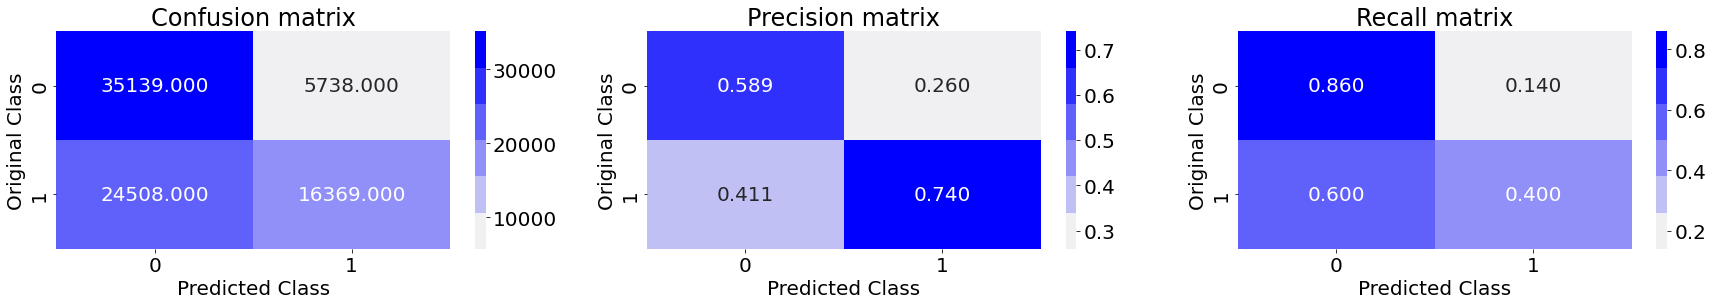

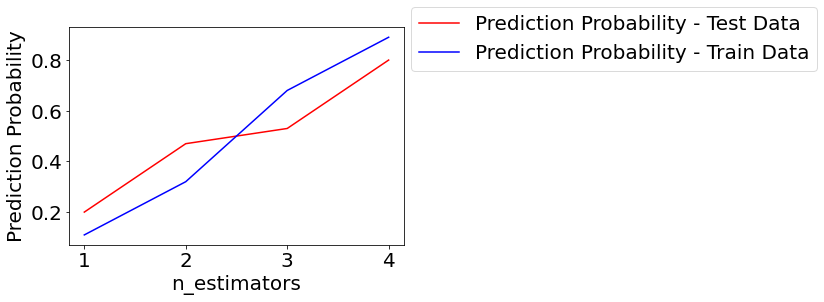

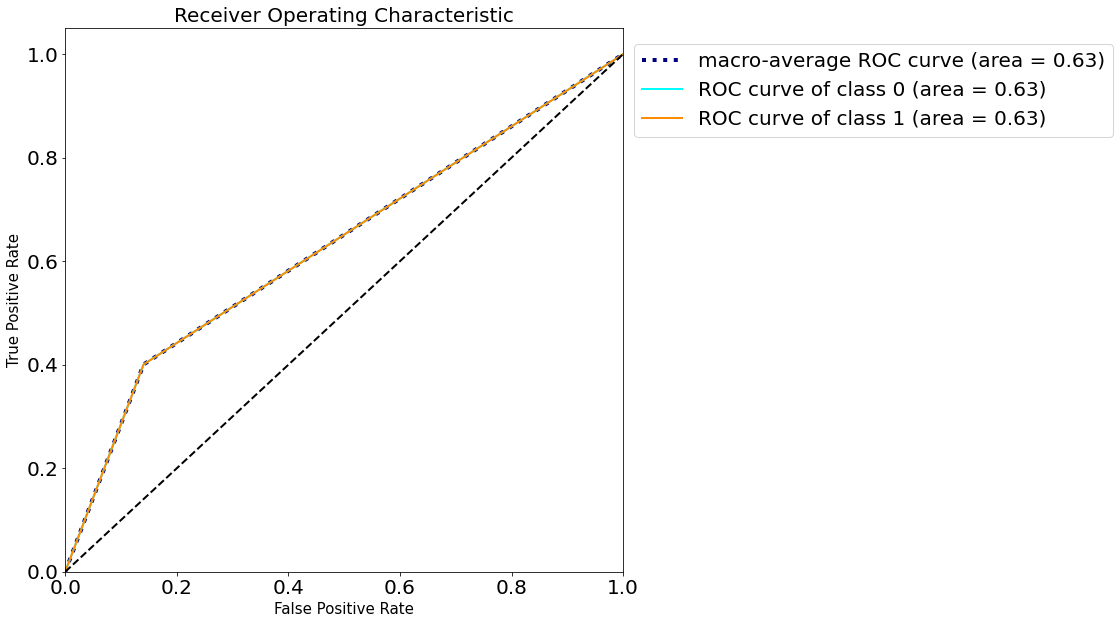

In [45]:
fpr = dict()
tpr = dict()
roc_auc = dict()
y_pred_proba = dict()
y_pred_proba_train = dict()

start = timer()
# Train random forest using reduced feature set
rf = RandomForestClassifier()
#print time taken to train and accuracy scores
rf.fit(x_train_after_svd, y_train)
print("Time taken for RF to train after TSVD :", timer()-start)
rf_tsvd_predict = rf.predict(x_test_after_svd)

print("\n***********Metrics for RF After TSVD ***********\n")
y_pred_proba = rf.predict_proba(x_test_after_svd)
y_pred_proba_train = rf.predict_proba(x_train_after_svd)
print("Log Loss: ", log_loss(y_val, y_pred_proba))
print("Confusion Matrix: ")
print(confusion_matrix(y_val, rf_tsvd_predict))
print("Classification Report")
print(classification_report(y_val, rf_tsvd_predict))
print("Accuracy Score: ",accuracy_score(y_val, rf_tsvd_predict))

plot_confusion_matrix(y_val, rf_tsvd_predict)

n_classes = 2
#claculate the prediction probability for each class
all_pred_test = np.unique(np.concatenate([y_pred_proba[i] for i in range(n_classes)]))
all_pred_train = np.unique(np.concatenate([y_pred_proba_train[i] for i in range(n_classes)]))
#plot the prediction probability
plot_predction_probability(all_pred_test,all_pred_train)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val, rf_tsvd_predict)
    roc_auc[i] = auc(fpr[i], tpr[i])

#plot the ROC metrics
plot_ROC_AUC(fpr, tpr,roc_auc)

In [13]:
#Clear the memory with Garbage Collect
gc.collect()

36

# Hyper Parameter Tuning with Cross Validation

In [14]:
rf = RandomForestClassifier(
    n_estimators=1000,
    criterion='gini',
    max_depth=200,
    bootstrap=True,
    n_jobs=-1,
    class_weight='balanced',
    min_samples_split = 5
)

# RF Hyperparameter tuned model CV = 3 with TSVD

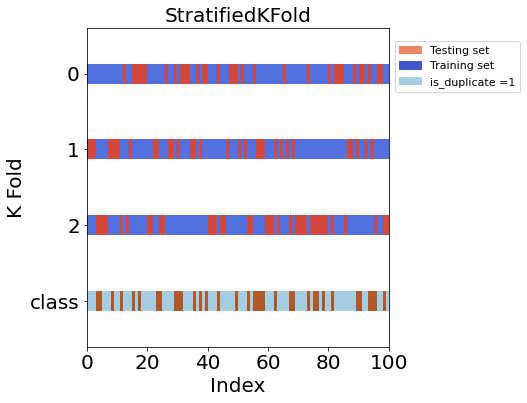

Time taken for RF to train with TSVD KFold :  0  :  397.4657378

***********Metrics for K-Fold With TSVD:  0  ***********

Log Loss:  0.38380686272307285
Confusion Matrix: 
[[45794  8588]
 [ 8028 46354]]
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.84      0.85     54382
           1       0.84      0.85      0.85     54382

    accuracy                           0.85    108764
   macro avg       0.85      0.85      0.85    108764
weighted avg       0.85      0.85      0.85    108764

Accuracy Score:  0.8472288624912655


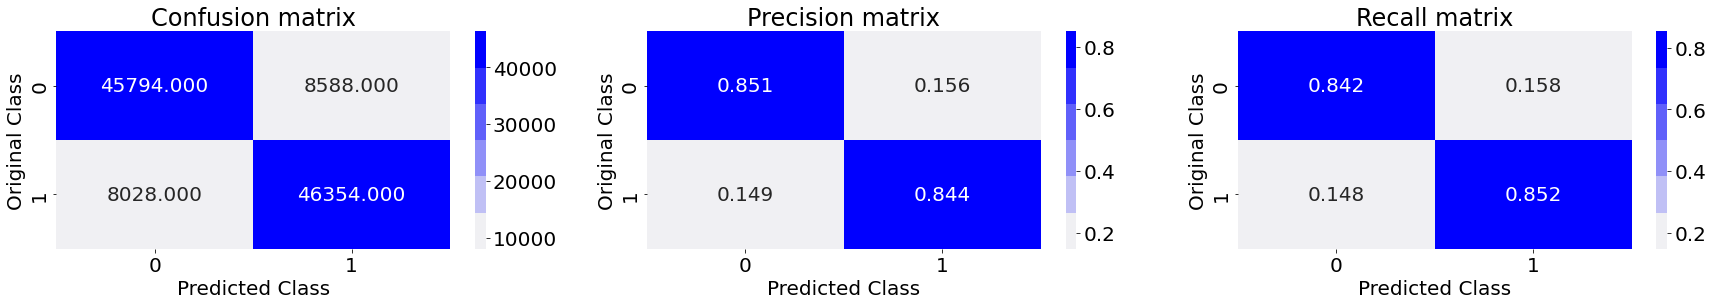

Time taken for RF to train with TSVD KFold :  1  :  386.52396150000004

***********Metrics for K-Fold With TSVD:  1  ***********

Log Loss:  0.3813914917435485
Confusion Matrix: 
[[45782  8600]
 [ 7658 46723]]
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     54382
           1       0.84      0.86      0.85     54381

    accuracy                           0.85    108763
   macro avg       0.85      0.85      0.85    108763
weighted avg       0.85      0.85      0.85    108763

Accuracy Score:  0.8505190184161894


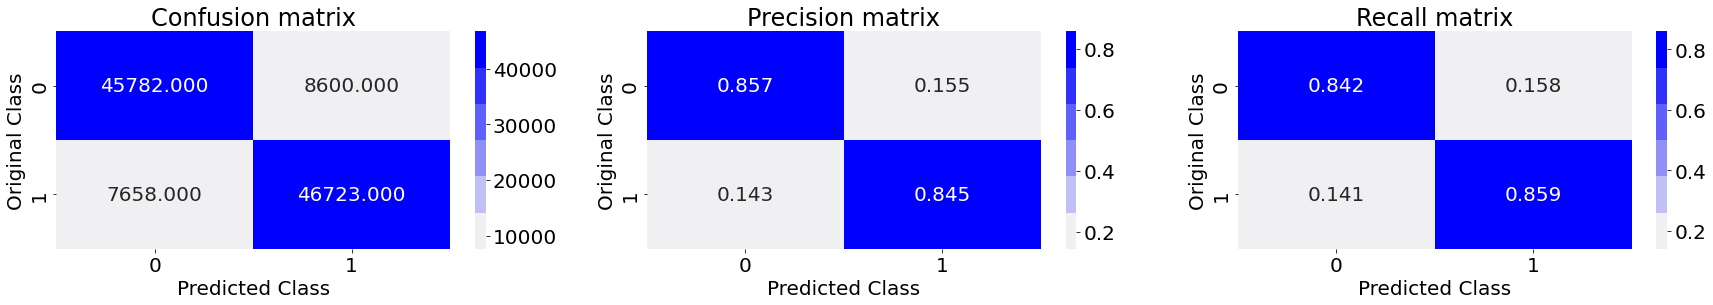

Time taken for RF to train with TSVD KFold :  2  :  389.6216792

***********Metrics for K-Fold With TSVD:  2  ***********

Log Loss:  0.38400988730230384
Confusion Matrix: 
[[45456  8925]
 [ 7755 46627]]
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.84      0.84     54381
           1       0.84      0.86      0.85     54382

    accuracy                           0.85    108763
   macro avg       0.85      0.85      0.85    108763
weighted avg       0.85      0.85      0.85    108763

Accuracy Score:  0.8466390224616828


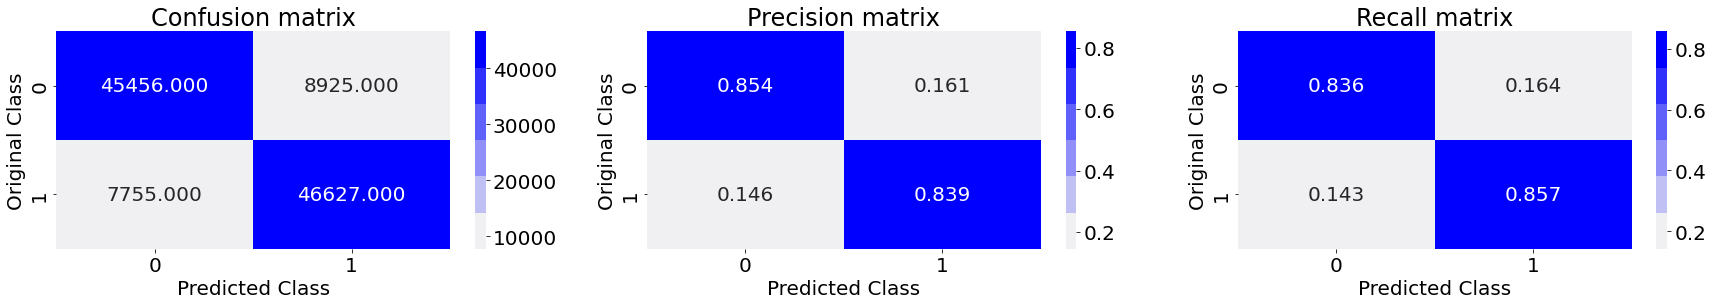

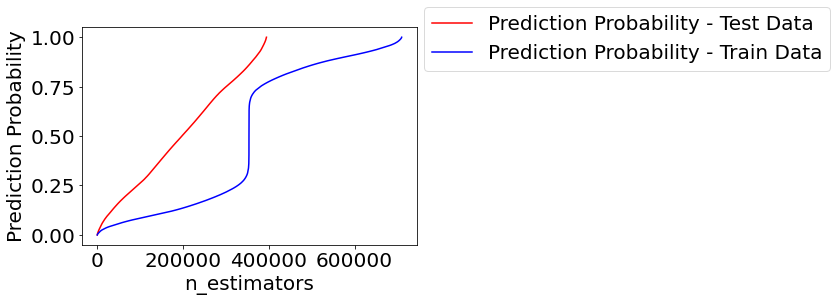

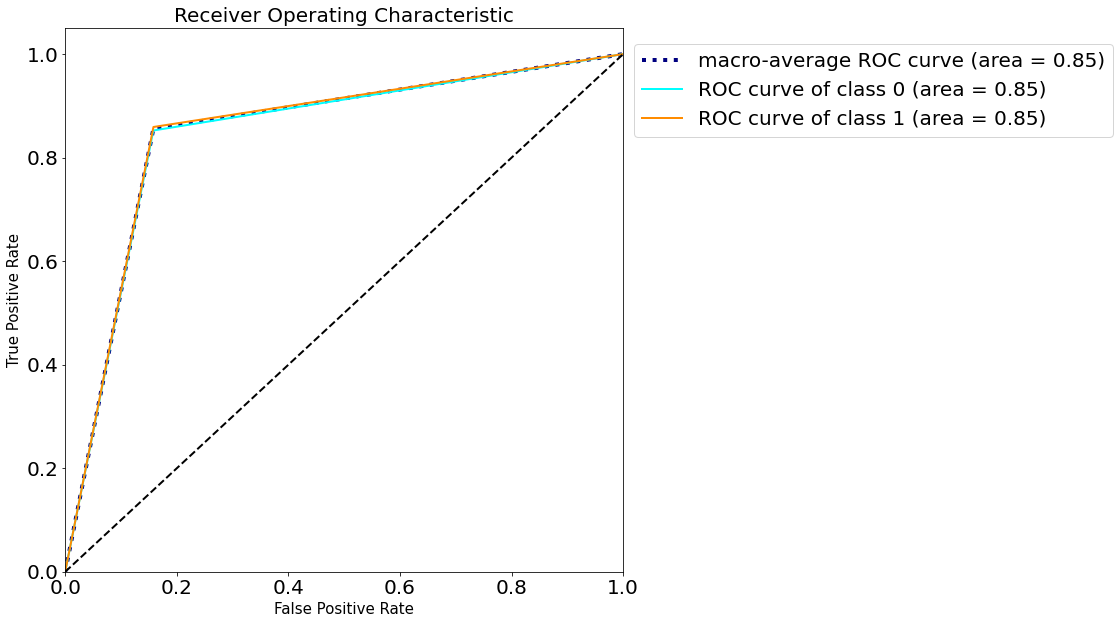

In [15]:
#plot the kfold data

n_splits = 3
cv = StratifiedKFold(n_splits=n_splits, random_state=123, shuffle=True)
plot_cv_indices(cv, x_train_after_svd, y_train,n_splits)

fpr = dict()
tpr = dict()
roc_auc = dict()

y_pred_proba = dict()
y_pred_proba_train = dict()

y_pred_log = dict()
y_pred_log_train = dict()

X = x_train_after_svd
y = y_train
#fig, ax = plt.subplots()
for (train, test), i in zip(cv.split(X, y), range(5)):
    start = timer()
    rf.fit(X[train], y.iloc[train])
    print("Time taken for RF to train with TSVD KFold : ",i, " : ", timer()-start)
    y_pred = rf.predict(X[test])
    y_pred_train = rf.predict(X[train])

    y_pred_proba[i] = rf.predict_proba(X[test])
    y_pred_proba_train[i] = rf.predict_proba(X[train])

    print("\n***********Metrics for K-Fold With TSVD: ",i, " ***********\n")
    print("Log Loss: ", log_loss(y.iloc[test], y_pred_proba[i]))
    print("Confusion Matrix: ")
    print(confusion_matrix(y.iloc[test], y_pred))
    print("Classification Report")
    print(classification_report(y.iloc[test], y_pred))
    print("Accuracy Score: ",accuracy_score(y.iloc[test], y_pred))

    plot_confusion_matrix(y.iloc[test], y_pred)

    fpr[i], tpr[i], _ = roc_curve(y.iloc[test], y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])


n_classes = 2
#claculate the prediction probability for each class
all_pred_test = np.unique(np.concatenate([y_pred_proba[i] for i in range(n_classes)]))
all_pred_train = np.unique(np.concatenate([y_pred_proba_train[i] for i in range(n_classes)]))
#plot the prediction probability
plot_predction_probability(all_pred_test,all_pred_train)
#plot the ROC metrics
plot_ROC_AUC(fpr, tpr,roc_auc)



In [20]:
gc.collect()

8341

# RF Hyperparameter tuned model CV = 3 without TSVD

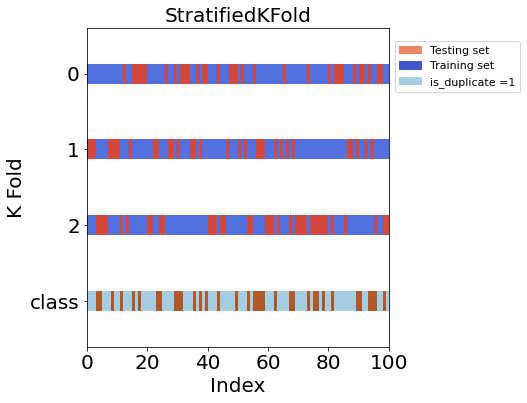

Time taken for RF to train with TSVD KFold :  0  :  487.4382053999998

***********Metrics for K-Fold With TSVD:  0  ***********

Log Loss:  0.29822598647737303
Confusion Matrix: 
[[46839  7543]
 [ 5033 49349]]
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     54382
           1       0.87      0.91      0.89     54382

    accuracy                           0.88    108764
   macro avg       0.89      0.88      0.88    108764
weighted avg       0.89      0.88      0.88    108764

Accuracy Score:  0.8843735059394653


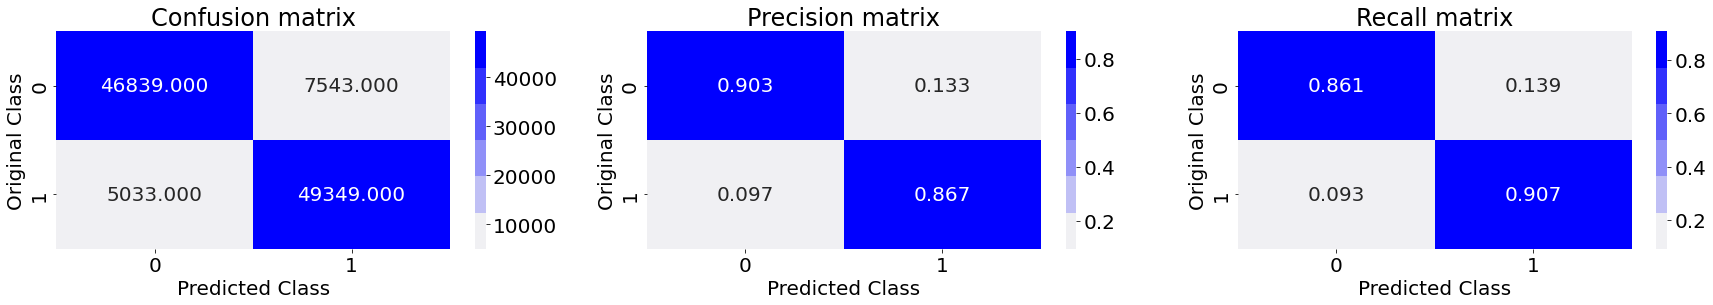

Time taken for RF to train with TSVD KFold :  1  :  482.9489907000002

***********Metrics for K-Fold With TSVD:  1  ***********

Log Loss:  0.2967543017712892
Confusion Matrix: 
[[46551  7831]
 [ 4699 49682]]
Classification Report
              precision    recall  f1-score   support

           0       0.91      0.86      0.88     54382
           1       0.86      0.91      0.89     54381

    accuracy                           0.88    108763
   macro avg       0.89      0.88      0.88    108763
weighted avg       0.89      0.88      0.88    108763

Accuracy Score:  0.8847953807820674


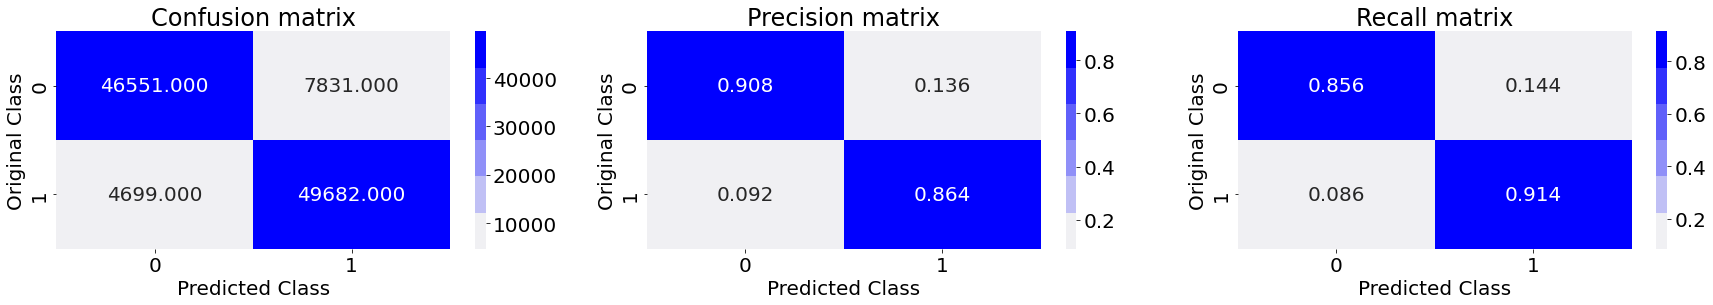

Time taken for RF to train with TSVD KFold :  2  :  467.88705579999987

***********Metrics for K-Fold With TSVD:  2  ***********

Log Loss:  0.29955183432336596
Confusion Matrix: 
[[46486  7895]
 [ 4903 49479]]
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.85      0.88     54381
           1       0.86      0.91      0.89     54382

    accuracy                           0.88    108763
   macro avg       0.88      0.88      0.88    108763
weighted avg       0.88      0.88      0.88    108763

Accuracy Score:  0.8823313075218595


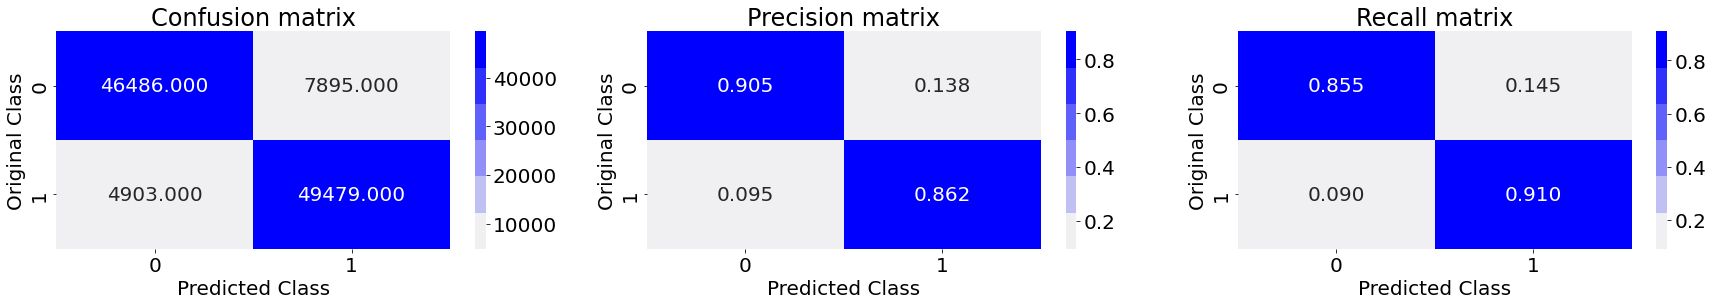

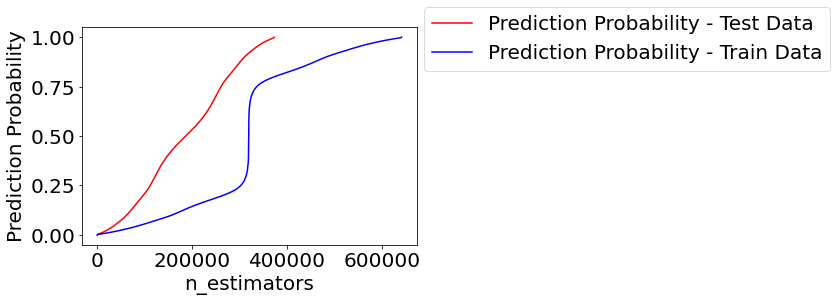

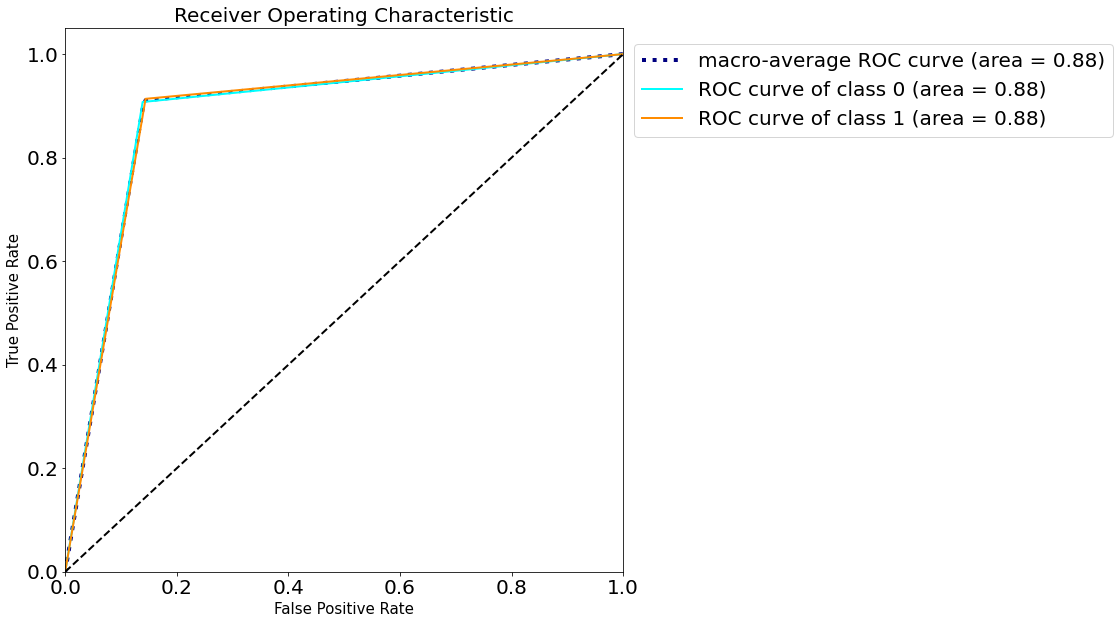

In [21]:
#plot the kfold data

n_splits = 3
cv = StratifiedKFold(n_splits=n_splits, random_state=123, shuffle=True)
plot_cv_indices(cv, x_train_normalized, y_train,n_splits)

fpr = dict()
tpr = dict()
roc_auc = dict()

y_pred_proba = dict()
y_pred_proba_train = dict()

y_pred_log = dict()
y_pred_log_train = dict()

X = x_train_normalized
y = y_train
#fig, ax = plt.subplots()
for (train, test), i in zip(cv.split(X, y), range(5)):
    start = timer()
    rf.fit(X[train], y.iloc[train])
    print("Time taken for RF to train with TSVD KFold : ",i, " : ", timer()-start)
    y_pred = rf.predict(X[test])
    y_pred_train = rf.predict(X[train])

    y_pred_proba[i] = rf.predict_proba(X[test])
    y_pred_proba_train[i] = rf.predict_proba(X[train])

    print("\n***********Metrics for K-Fold With TSVD: ",i, " ***********\n")
    print("Log Loss: ", log_loss(y.iloc[test], y_pred_proba[i]))
    print("Confusion Matrix: ")
    print(confusion_matrix(y.iloc[test], y_pred))
    print("Classification Report")
    print(classification_report(y.iloc[test], y_pred))
    print("Accuracy Score: ",accuracy_score(y.iloc[test], y_pred))

    plot_confusion_matrix(y.iloc[test], y_pred)

    fpr[i], tpr[i], _ = roc_curve(y.iloc[test], y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])


n_classes = 2
#claculate the prediction probability for each class
all_pred_test = np.unique(np.concatenate([y_pred_proba[i] for i in range(n_classes)]))
all_pred_train = np.unique(np.concatenate([y_pred_proba_train[i] for i in range(n_classes)]))
#plot the prediction probability
plot_predction_probability(all_pred_test,all_pred_train)
#plot the ROC metrics
plot_ROC_AUC(fpr, tpr,roc_auc)


In [22]:
gc.collect()

51345

# RF Calibrated Prefit Model without TSVD

In [40]:
from sklearn.calibration import CalibratedClassifierCV
x_cal = x_train_normalized
y_cal = y_train

X_train_cal, y_train_cal = x_cal[:180000], y_cal[:180000]
X_valid_cal, y_valid_cal = x_cal[180000:301372], y_cal[180000:301372]
X_train_valid_cal, y_train_valid_cal = x_cal[:10000], y_cal[:10000]
X_test_cal, y_test_cal = x_cal[10000:], y_cal[10000:]

clf =  RandomForestClassifier(
    n_estimators=1000,
    criterion='gini',
    max_depth=200,
    bootstrap=True,
    n_jobs=-1,
    class_weight='balanced',
    min_samples_split = 5
)
clf.fit(X_train_valid_cal, y_train_valid_cal)

clf =  RandomForestClassifier(
    n_estimators=1000,
    criterion='gini',
    max_depth=200,
    bootstrap=True,
    n_jobs=-1,
    class_weight='balanced',
    min_samples_split = 5
)
clf.fit(X_train_cal, y_train_cal)

cal_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
start = timer()
cal_clf.fit(X_valid_cal, y_valid_cal)
print("Time taken for RF to train without TSVD - Prefit Calibrated", timer()-start)


clf_probs = clf.predict_proba(X_test_cal)
cal_clf_probs = cal_clf.predict_proba(X_test_cal)

clf_pred = clf.predict(X_test_cal)
cal_clf_pred = cal_clf.predict(X_test_cal)

score = log_loss(y_test_cal, clf_probs)
cal_score = log_loss(y_test_cal, cal_clf_probs)

print("Log-loss of")
print(f" * uncalibrated classifier: {score:.3f}")
print(f" * calibrated classifier: {cal_score:.3f}")


Log-loss of
 * uncalibrated classifier: 0.216
 * calibrated classifier: 0.131


Confusion Matrix: 
[[149145   7811]
 [  9298 150036]]
Classification Report
              precision    recall  f1-score   support

           0       0.94      0.95      0.95    156956
           1       0.95      0.94      0.95    159334

    accuracy                           0.95    316290
   macro avg       0.95      0.95      0.95    316290
weighted avg       0.95      0.95      0.95    316290

Accuracy Score:  0.9459072370293086


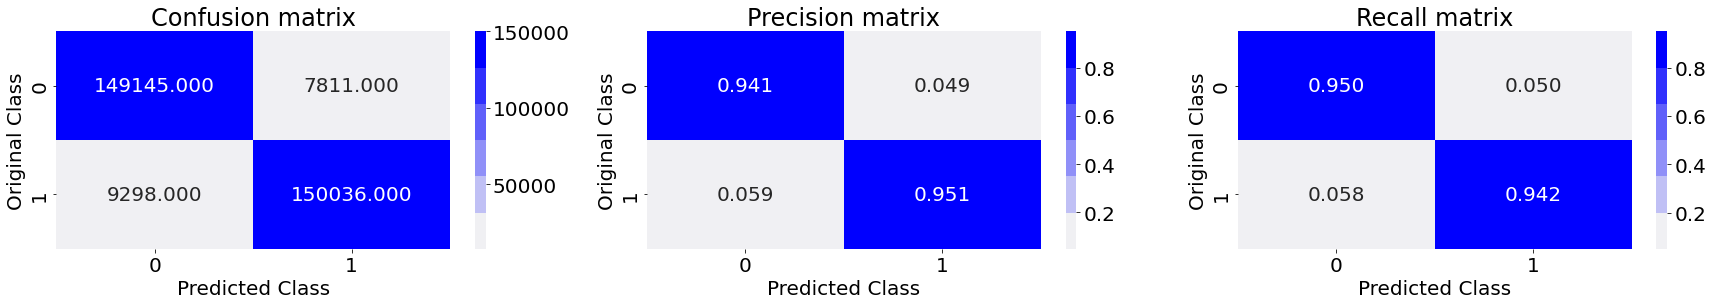

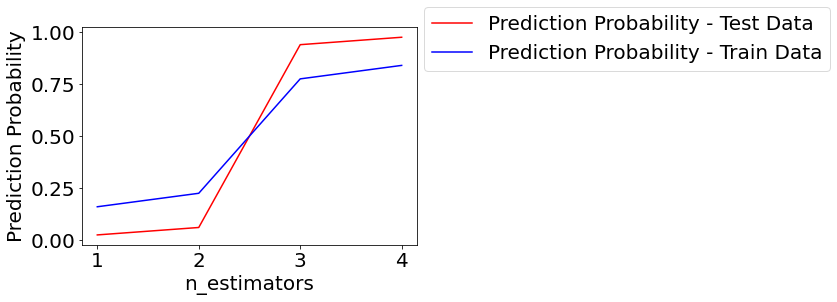

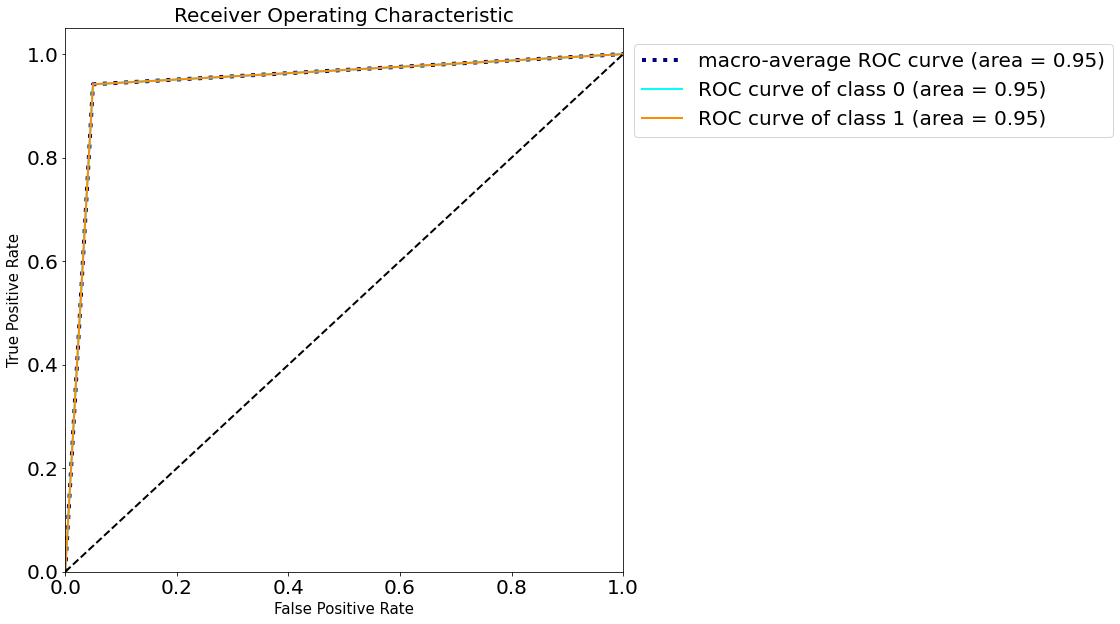

In [41]:
fpr = dict()
tpr = dict()
roc_auc = dict()
y_pred_proba = dict()
y_pred_proba_train = dict()
y_pred_log = dict()
y_pred_log_train = dict()

print("Confusion Matrix: ")
print(confusion_matrix(y_test_cal, cal_clf_pred))
print("Classification Report")
print(classification_report(y_test_cal, cal_clf_pred))
print("Accuracy Score: ",accuracy_score(y_test_cal, cal_clf_pred))

plot_confusion_matrix(y_test_cal, cal_clf_pred)

#Used to plot the prediction probability of the model
y_pred_proba = cal_clf_probs
y_pred_proba_train = clf.predict_proba(X_test_cal)


n_classes = 2
#claculate the prediction probability for each class
all_pred_test = np.unique(np.concatenate([y_pred_proba[i] for i in range(n_classes)]))
all_pred_train = np.unique(np.concatenate([y_pred_proba_train[i] for i in range(n_classes)]))
#plot the prediction probability
plot_predction_probability(all_pred_test,all_pred_train)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cal, cal_clf_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

#plot the ROC metrics
plot_ROC_AUC(fpr, tpr,roc_auc)

# RF Calibrated Prefit Model with TSVD

Time taken for RF to train without TSVD - Prefit Calibrated 5.641620700000203
Log-loss of
 * uncalibrated classifier: 0.277
 * calibrated classifier: 0.174
Confusion Matrix: 
[[147086   9870]
 [ 13457 145877]]
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.94      0.93    156956
           1       0.94      0.92      0.93    159334

    accuracy                           0.93    316290
   macro avg       0.93      0.93      0.93    316290
weighted avg       0.93      0.93      0.93    316290

Accuracy Score:  0.9262480634860413


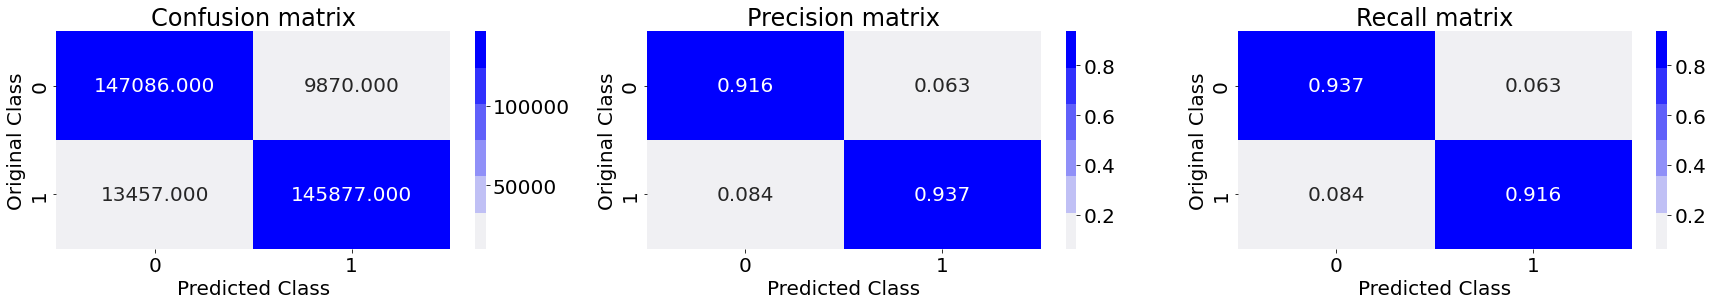

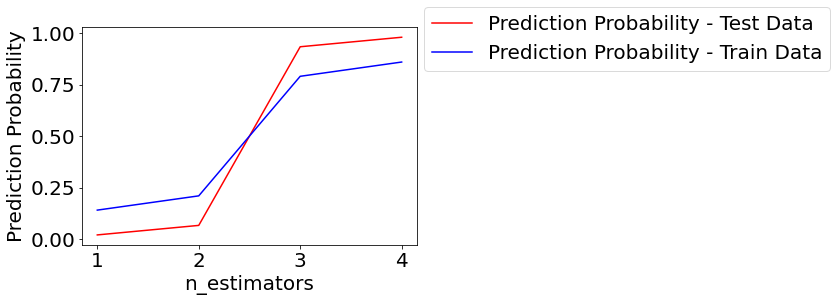

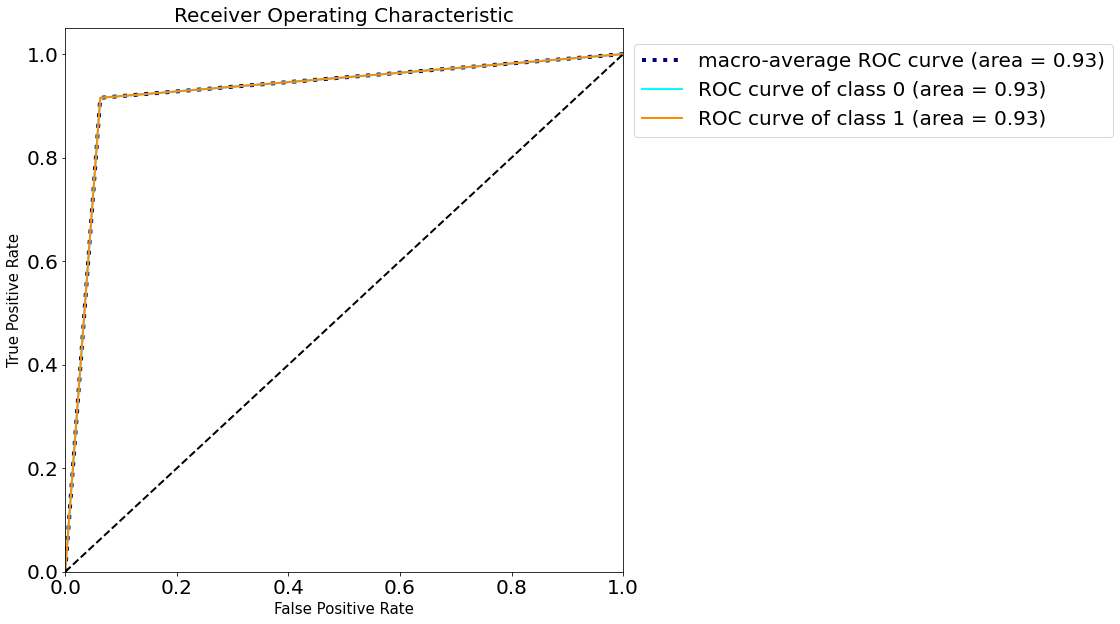

In [42]:
from sklearn.calibration import CalibratedClassifierCV

x_cal = x_train_after_svd
y_cal = y_train

X_train_cal, y_train_cal = x_cal[:180000], y_cal[:180000]
X_valid_cal, y_valid_cal = x_cal[180000:301372], y_cal[180000:301372]
X_train_valid_cal, y_train_valid_cal = x_cal[:10000], y_cal[:10000]
X_test_cal, y_test_cal = x_cal[10000:], y_cal[10000:]

clf = RandomForestClassifier(
    n_estimators=1000,
    criterion='gini',
    max_depth=200,
    bootstrap=True,
    n_jobs=-1,
    class_weight='balanced',
    min_samples_split=5
)
clf.fit(X_train_valid_cal, y_train_valid_cal)

clf = RandomForestClassifier(
    n_estimators=1000,
    criterion='gini',
    max_depth=200,
    bootstrap=True,
    n_jobs=-1,
    class_weight='balanced',
    min_samples_split=5
)
clf.fit(X_train_cal, y_train_cal)

cal_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
start = timer()
cal_clf.fit(X_valid_cal, y_valid_cal)
print("Time taken for RF to train with TSVD - Prefit Calibrated", timer()-start)


clf_probs = clf.predict_proba(X_test_cal)
cal_clf_probs = cal_clf.predict_proba(X_test_cal)

clf_pred = clf.predict(X_test_cal)
cal_clf_pred = cal_clf.predict(X_test_cal)

score = log_loss(y_test_cal, clf_probs)
cal_score = log_loss(y_test_cal, cal_clf_probs)

print("Log-loss of")
print(f" * uncalibrated classifier: {score:.3f}")
print(f" * calibrated classifier: {cal_score:.3f}")

fpr = dict()
tpr = dict()
roc_auc = dict()
y_pred_proba = dict()
y_pred_proba_train = dict()
y_pred_log = dict()
y_pred_log_train = dict()

print("Confusion Matrix: ")
print(confusion_matrix(y_test_cal, cal_clf_pred))
print("Classification Report")
print(classification_report(y_test_cal, cal_clf_pred))
print("Accuracy Score: ", accuracy_score(y_test_cal, cal_clf_pred))

plot_confusion_matrix(y_test_cal, cal_clf_pred)

#Used to plot the prediction probability of the model
y_pred_proba = cal_clf_probs
y_pred_proba_train = clf.predict_proba(X_test_cal)

n_classes = 2
#claculate the prediction probability for each class
all_pred_test = np.unique(np.concatenate([y_pred_proba[i] for i in range(n_classes)]))
all_pred_train = np.unique(np.concatenate([y_pred_proba_train[i] for i in range(n_classes)]))
#plot the prediction probability
plot_predction_probability(all_pred_test, all_pred_train)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cal, cal_clf_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

#plot the ROC metrics
plot_ROC_AUC(fpr, tpr, roc_auc)

# Testing RF Best Calibrated Model with Test Data

In [23]:
#Read the dataset
df = pd.read_csv("Final_Test_V01.csv")

In [24]:
#Read all features except Target features as X
#Read target feature as y
x_final_test = df.drop('is_duplicate',axis=1).to_numpy()
y_final_test = df['is_duplicate'].to_numpy()

In [25]:
#Normalize the Data
sc = StandardScaler()
x_final_test_normalized = sc.fit_transform(x_final_test)

Log Loss:  0.39058069659073114
Confusion Matrix: 
[[41763  9242]
 [ 4770 25083]]
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     51005
           1       0.73      0.84      0.78     29853

    accuracy                           0.83     80858
   macro avg       0.81      0.83      0.82     80858
weighted avg       0.84      0.83      0.83     80858

Accuracy Score:  0.8267085507927477


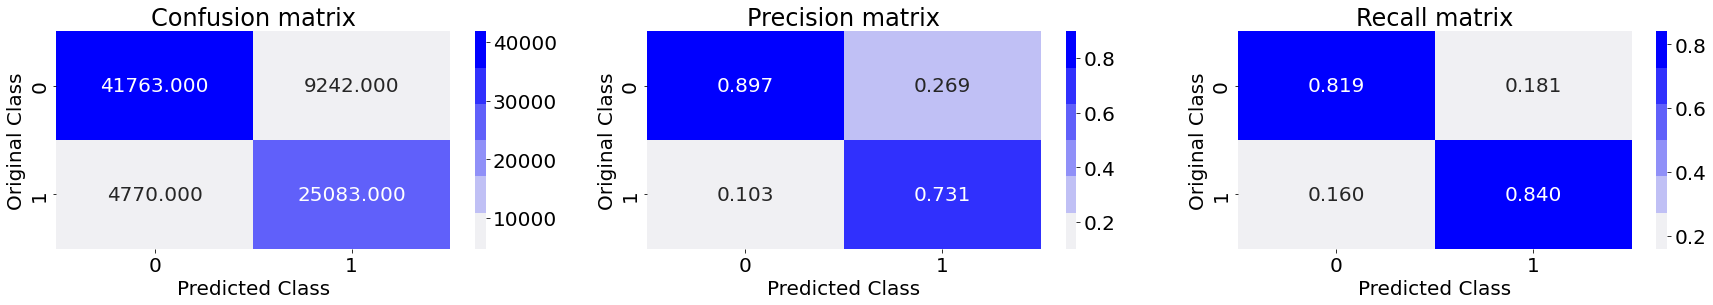

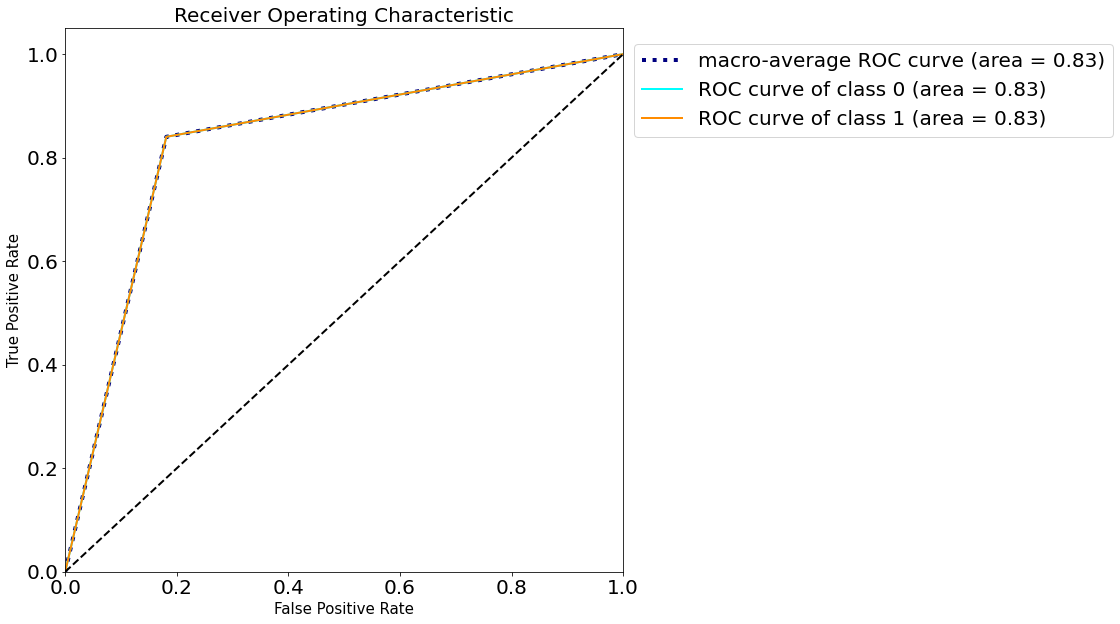

In [28]:
fpr = dict()
tpr = dict()
roc_auc = dict()
y_pred_proba = dict()


#Used to plot the prediction probability of the model
y_pred_proba = rf.predict_proba(x_final_test_normalized)
y_pred = rf.predict(x_final_test_normalized)
print("Log Loss: ", log_loss(y_final_test, y_pred_proba))
print("Confusion Matrix: ")
print(confusion_matrix(y_final_test, y_pred))
print("Classification Report")
print(classification_report(y_final_test, y_pred))
print("Accuracy Score: ",accuracy_score(y_final_test, y_pred))

plot_confusion_matrix(y_final_test, y_pred)
n_classes = 2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_final_test, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

#plot the ROC metrics
plot_ROC_AUC(fpr, tpr,roc_auc)

# RF Calibrated Model, CV = 3 without TSVD (Training/Validation and Testing)

In [29]:
X_train_cal = x_train_normalized
y_train_cal = y_train
X_valid_cal = x_test_normalized
y_valid_cal = y_val
x_cal_final = x_final_test_normalized
y_cal_final = y_final_test

Time taken for RF to train without TSVD (Calibrated) 788.6401619000007
Time taken for RF to train without TSVD (Calibrated) 1541.6669225999995
                         Brier  loss  Log loss  Precision    Recall   \
Classifier                                                             
Random Forest               0.120650  0.378364    0.765689  0.801059   
Random Forest + Sigmoid     0.115899  0.352511    0.843782  0.641577   

                              F1   Roc auc   Accuracy   
Classifier                                              
Random Forest            0.782975  0.828791   0.836046  
Random Forest + Sigmoid  0.728916  0.786027   0.823815  


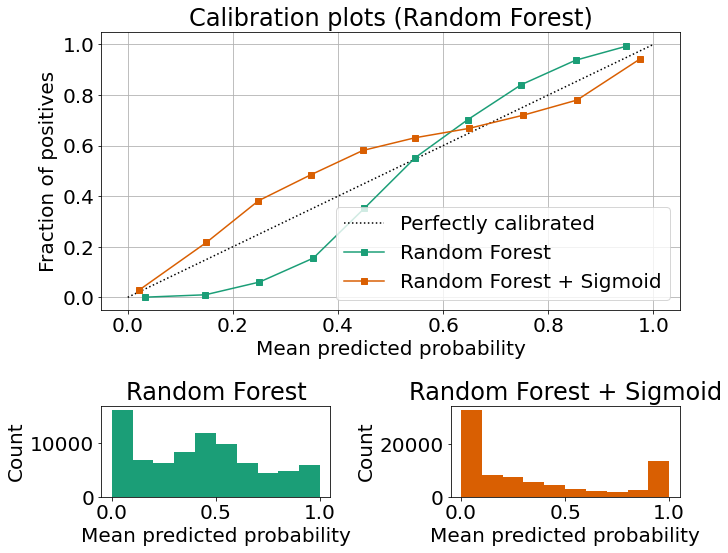

In [30]:
from sklearn.calibration import CalibratedClassifierCV
from collections import defaultdict
from sklearn.calibration import CalibrationDisplay
from matplotlib.gridspec import GridSpec
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    brier_score_loss,
    log_loss,
    roc_auc_score,
    accuracy_score,
)

clf_plot =  RandomForestClassifier(
    n_estimators=1000,
    criterion='gini',
    max_depth=200,
    bootstrap=True,
    n_jobs=-1,
    class_weight='balanced',
    min_samples_split = 5
)

cal_clf_plot = CalibratedClassifierCV(clf_plot, cv=3, method="sigmoid")
clf_list = [
    (clf_plot, "Random Forest"),
    (cal_clf_plot, "Random Forest + Sigmoid"),
]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    start = timer()
    clf.fit(X_train_cal, y_train_cal)
    print("Time taken for RF to train without TSVD (Calibrated)", timer()-start)
    display = CalibrationDisplay.from_estimator(
        clf,
        x_cal_final,
        y_cal_final,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display
    y_prob_plot = clf.predict_proba(x_cal_final)
    y_pred_plot = clf.predict(x_cal_final)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_cal_final, y_prob_plot[:, 1]))

    for metric in [precision_score, recall_score, f1_score, roc_auc_score,accuracy_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_cal_final, y_pred_plot))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

print(score_df)
ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Random Forest)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [34]:
score_df

,Brier loss,Log loss,Precision,Recall,F1,Roc auc,Accuracy
Classifier,,,,,,,
Random Forest,0.120650,0.378364,0.765689,0.801059,0.782975,0.828791,0.836046
Random Forest + Sigmoid,0.115899,0.352511,0.843782,0.641577,0.728916,0.786027,0.823815


In [35]:
gc.collect()

105

# RF Calibrated Model, CV = 3 with TSVD (Training/Validation and Testing)

In [32]:
#Reduce 629 to 300 features using TSVD
n_components = 300
svd_x_final = TruncatedSVD(n_components=n_components)
svd_x_final.fit(x_final_test_normalized)
x_test_after_svd_final = svd_x_final.transform(x_final_test_normalized)

In [36]:
X_train_cal = x_train_after_svd
y_train_cal = y_train
X_valid_cal = x_test_after_svd
y_valid_cal = y_val
x_cal_final = x_test_after_svd_final
y_cal_final = y_final_test

Time taken for RF to train without TSVD - Prefit Calibrated 6.311163900001702
Log-loss of
 * uncalibrated classifier: 0.380
 * calibrated classifier: 0.378
Confusion Matrix: 
[[40960 10045]
 [ 4387 25466]]
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.80      0.85     51005
           1       0.72      0.85      0.78     29853

    accuracy                           0.82     80858
   macro avg       0.81      0.83      0.81     80858
weighted avg       0.83      0.82      0.82     80858

Accuracy Score:  0.821514259566153


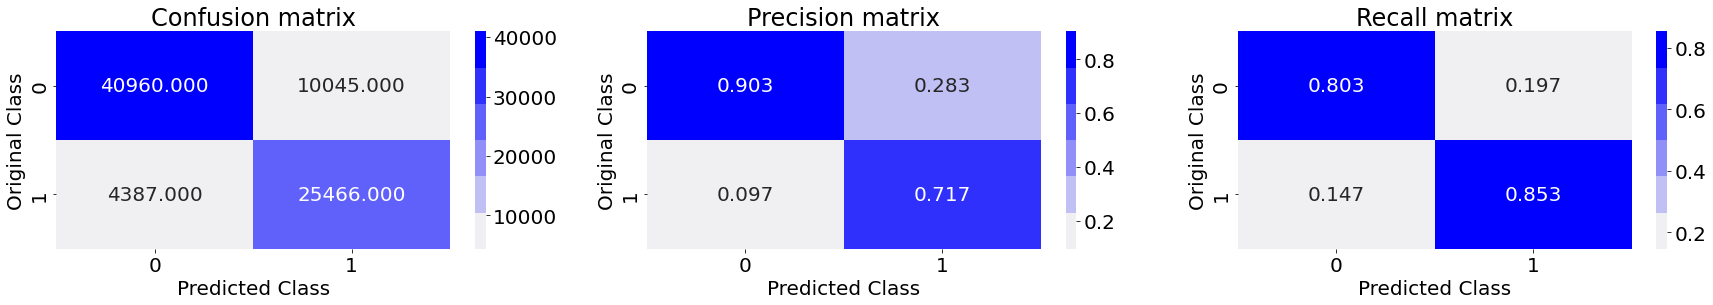

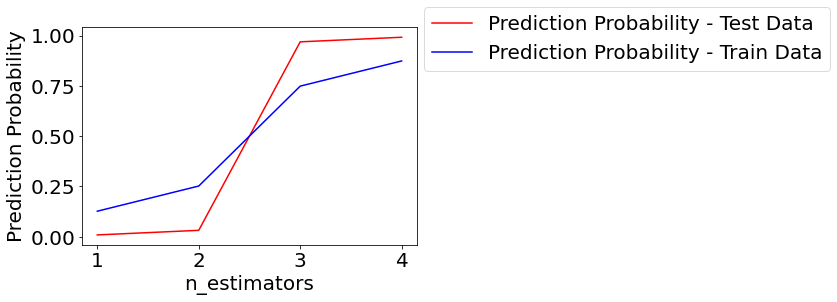

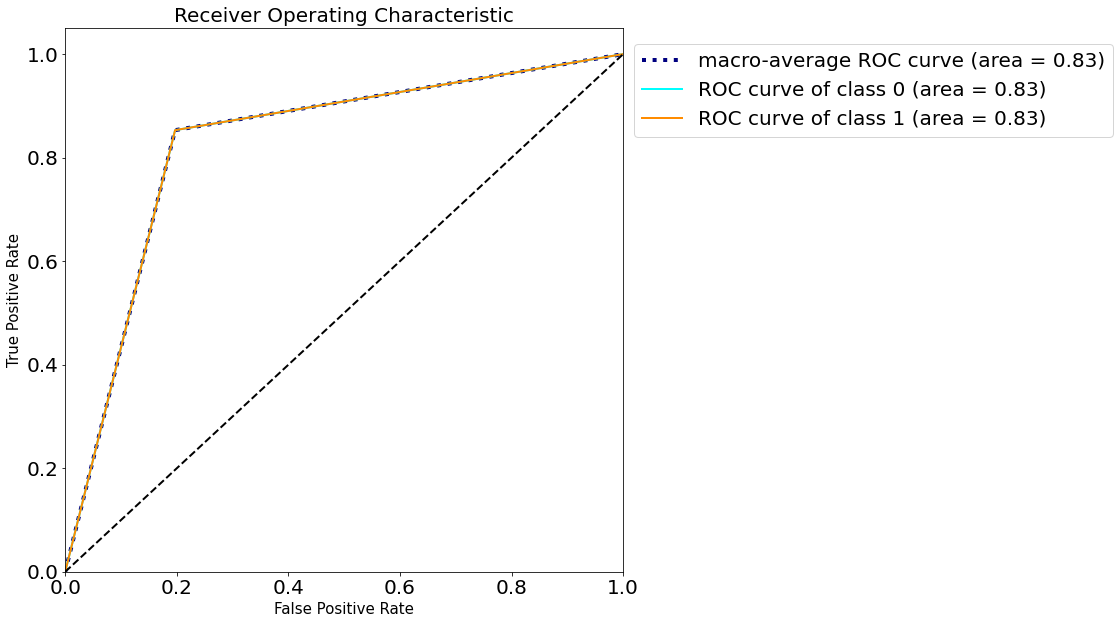

In [44]:
from sklearn.calibration import CalibratedClassifierCV

x_cal = x_train_normalized
y_cal = y_train

X_train_cal, y_train_cal = x_cal[:180000], y_cal[:180000]
X_valid_cal, y_valid_cal = x_cal[180000:301372], y_cal[180000:301372]
X_train_valid_cal, y_train_valid_cal = x_cal[:10000], y_cal[:10000]
X_test_cal, y_test_cal = x_final_test_normalized,y_final_test


clf = RandomForestClassifier(
    n_estimators=1000,
    criterion='gini',
    max_depth=200,
    bootstrap=True,
    n_jobs=-1,
    class_weight='balanced',
    min_samples_split=5
)
clf.fit(X_train_valid_cal, y_train_valid_cal)

clf = RandomForestClassifier(
    n_estimators=1000,
    criterion='gini',
    max_depth=200,
    bootstrap=True,
    n_jobs=-1,
    class_weight='balanced',
    min_samples_split=5
)
clf.fit(X_train_cal, y_train_cal)

cal_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
start = timer()
cal_clf.fit(X_valid_cal, y_valid_cal)
print("Time taken for RF to train without TSVD - Prefit Calibrated", timer()-start)


clf_probs = clf.predict_proba(X_test_cal)
cal_clf_probs = cal_clf.predict_proba(X_test_cal)

clf_pred = clf.predict(X_test_cal)
cal_clf_pred = cal_clf.predict(X_test_cal)

score = log_loss(y_test_cal, clf_probs)
cal_score = log_loss(y_test_cal, cal_clf_probs)

print("Log-loss of")
print(f" * uncalibrated classifier: {score:.3f}")
print(f" * calibrated classifier: {cal_score:.3f}")

fpr = dict()
tpr = dict()
roc_auc = dict()
y_pred_proba = dict()
y_pred_proba_train = dict()
y_pred_log = dict()
y_pred_log_train = dict()

print("Confusion Matrix: ")
print(confusion_matrix(y_test_cal, cal_clf_pred))
print("Classification Report")
print(classification_report(y_test_cal, cal_clf_pred))
print("Accuracy Score: ", accuracy_score(y_test_cal, cal_clf_pred))

plot_confusion_matrix(y_test_cal, cal_clf_pred)

#Used to plot the prediction probability of the model
y_pred_proba = cal_clf_probs
y_pred_proba_train = clf.predict_proba(X_test_cal)

n_classes = 2
#claculate the prediction probability for each class
all_pred_test = np.unique(np.concatenate([y_pred_proba[i] for i in range(n_classes)]))
all_pred_train = np.unique(np.concatenate([y_pred_proba_train[i] for i in range(n_classes)]))
#plot the prediction probability
plot_predction_probability(all_pred_test, all_pred_train)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cal, cal_clf_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

#plot the ROC metrics
plot_ROC_AUC(fpr, tpr, roc_auc)